In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers import Conv1D, Flatten, Dropout, Dense, LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import np_utils

from tqdm import tqdm
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

#from lime import lime_text
#from lime.lime_text import LimeTextExplainer

Using TensorFlow backend.


In [2]:
def init(embeddings_type = 'w2v'):
    if embeddings_type == 'w2v':    
        global w2vModel
        w2vModel = load_w2v_embeddings(w2v_path)
    else:
        raise NameError('Invalid embedding type {}'.format(embeddings_type))
        
def get_embeddings(embeddings_type = 'w2v'):
    if embeddings_type == 'w2v':
        global w2vModel
        try:
            return w2vModel
        except NameError:
            init(embeddings_type)
            return w2vModel
    else:
        raise NameError('Invalid embedding type %s' % embeddings_type)

def load_w2v_embeddings(path):
    w2vModel = gensim.models.KeyedVectors.load_word2vec_format(path, 
                                                               binary=False)
    return w2vModel 

class FixedSizeArray(BaseEstimator, TransformerMixin):
    def __init__(self, dimensions, steps, word2vec_mod=None):
        self.dim = dimensions
        self.steps = steps
        self.w2v = word2vec_mod
        
    def fit_transform(self, texts, y=None):
        return self.transform(texts, y)
    
    def fit(self, texts):
        return None
    
    def _transform(self, article):
        tokens = CountVectorizer().build_tokenizer()(article) 
        doc_vectors_gen = (self.w2v[a].tolist() for a in tokens if a in self.w2v.vocab)
        doc_vectors = [a for (i, a) in enumerate(doc_vectors_gen) if i <self.steps]
        
        while len(doc_vectors) < self.steps:
            doc_vectors.append([0])
    
        pad_vectors = pad_sequences(doc_vectors,padding='post',dtype='float32', maxlen=self.dim, value=0.)
        return pad_vectors
    
    def transform(self, sentences, y=None):
        
        if self.w2v == None:
            print("Lazy loading embeddings...")
            self.w2v = get_embeddings('w2v')
        
        sentences = [eval(i) for i in sentences]
        return np.array([self._transform(' '.join(i)) for i in sentences])
    
def plot_training(history):
    plt.figure(figsize=(12, 12))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.figure(figsize=(12, 12))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    
def create_conv_model(dropout, kernel_size=3):
    model = Sequential()
    model.add(Conv1D(64, kernel_size, input_shape=(10, 100), padding='same'))
    model.add(Conv1D(32, kernel_size, padding='same'))
    model.add(Conv1D(16, kernel_size, padding='same'))
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(180, activation='sigmoid'))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax'))
    return model

def create_simple_LSTM_model():
    model = Sequential()
    model.add(LSTM(128, input_shape = (10, 100), return_sequences=True))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    return model

def create_LSTM_model():
    model = Sequential()
    model.add(LSTM(256, input_shape = (10, 100), return_sequences=True, recurrent_dropout=0.2))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(128, return_sequences=True, recurrent_dropout=0.2))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    return model

In [3]:
class NeuralNet(BaseEstimator, ClassifierMixin):
    
    def __init__(self, model, name=None, validation_size=0.1, batchsize = 256, epochs = 10):
        self.model = model
        self.model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
        self.early_stopping = EarlyStopping(patience=2)
        self.checkpointer = ModelCheckpoint(filepath='weights.tmp.h5', verbose=1, save_best_only=True)
        self.tensorboard = TensorBoard(log_dir="logs/{}-{}".format(name,time.time()))
        self.batchsize = batchsize
        self.epochs = epochs
        self.validation_size = validation_size
        
    def fit(self, X, y):
        
        history = self.model.fit(X, 
                                 y, 
                                 validation_split=self.validation_size, 
                                 batch_size=self.batchsize, 
                                 epochs=self.epochs, 
                                 callbacks=[self.checkpointer, 
                                            self.early_stopping, 
                                            self.tensorboard] if self.validation_size != 0
                                else [self.checkpointer, self.tensorboard])
        self.history = history
        
    def predict(self, X):
        return self.model.predict(X)

In [4]:
data_path = 'data/Data - sentiment classification.csv'
w2v_path = 'data/nkjp+wiki-forms-all-100-cbow-hs.txt'

In [5]:
df = pd.read_csv(data_path, sep = '\t').drop('id', axis=1)
y = df.loc[:, 'sentiment'].values
x = df.loc[:, 'tokens'].values

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
dummy_y = np_utils.to_categorical(encoded_y)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(x, dummy_y, test_size=0.33, random_state=42)

### Simple LSTM

Lazy loading embeddings...
Train on 24963 samples, validate on 2774 samples
Epoch 1/10
24963/24963 [==============================] - 4s 172us/step - loss: 0.3444 - acc: 0.8417 - val_loss: 0.2579 - val_acc: 0.8815

Epoch 00001: val_loss improved from inf to 0.25787, saving model to weights.tmp.h5
Epoch 2/10
24963/24963 [==============================] - 6s 231us/step - loss: 0.2419 - acc: 0.8892 - val_loss: 0.2371 - val_acc: 0.8910

Epoch 00002: val_loss improved from 0.25787 to 0.23705, saving model to weights.tmp.h5
Epoch 3/10
24963/24963 [==============================] - 5s 215us/step - loss: 0.2141 - acc: 0.9043 - val_loss: 0.2239 - val_acc: 0.9003

Epoch 00003: val_loss improved from 0.23705 to 0.22393, saving model to weights.tmp.h5
Epoch 4/10
24963/24963 [==============================] - 5s 218us/step - loss: 0.1911 - acc: 0.9169 - val_loss: 0.2172 - val_acc: 0.9078

Epoch 00004: val_loss improved from 0.22393 to 0.21718, saving model to weights.tmp.h5
Epoch 5/10
24963/24963 [

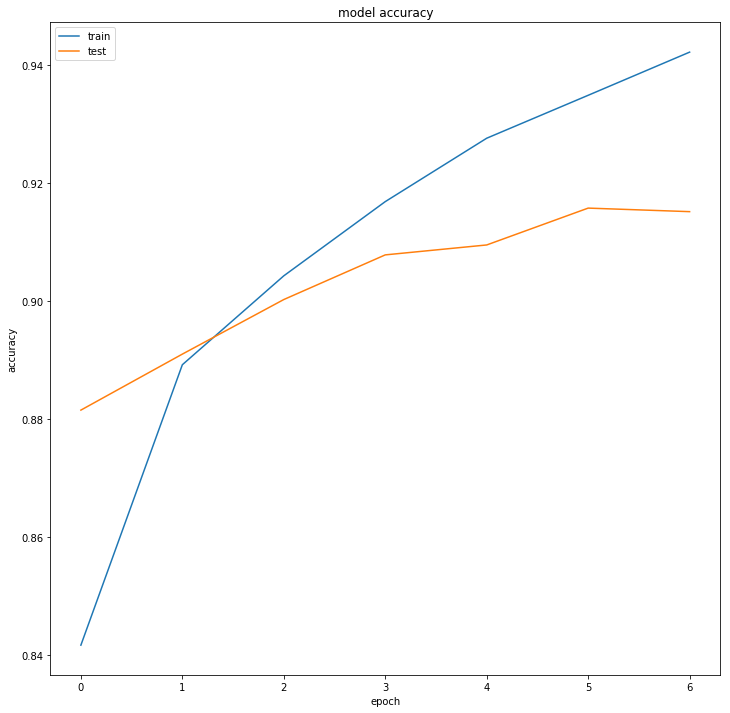

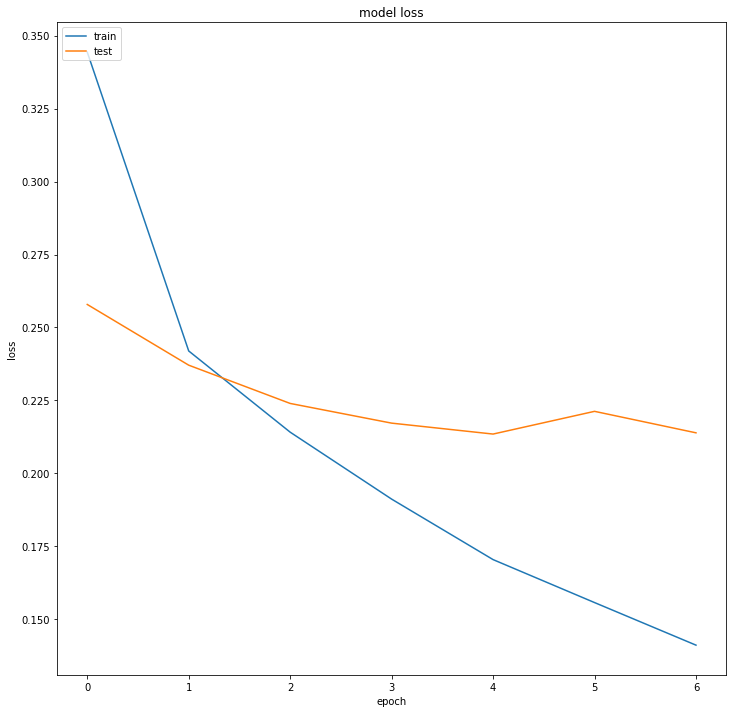

In [13]:
model = Pipeline([
    ('fsa', FixedSizeArray(100,10)),
    ('nn', NeuralNet(create_simple_LSTM_model(), 'simple_LSTM')),
])

model.fit(X_train, y_train)

plot_training(model.steps[1][1].history) 

In [14]:
accuracy_score(model.predict(X_test).argmax(axis=1), y_test.astype(int).argmax(axis=1))

0.855877616747182

### LSTM

Lazy loading embeddings...
Train on 24963 samples, validate on 2774 samples
Epoch 1/10
24963/24963 [==============================] - 16s 659us/step - loss: 0.3306 - acc: 0.8488 - val_loss: 0.2733 - val_acc: 0.8780

Epoch 00001: val_loss improved from inf to 0.27331, saving model to weights.tmp.h5
Epoch 2/10
24963/24963 [==============================] - 14s 578us/step - loss: 0.2478 - acc: 0.8860 - val_loss: 0.2410 - val_acc: 0.8939

Epoch 00002: val_loss improved from 0.27331 to 0.24099, saving model to weights.tmp.h5
Epoch 3/10
24963/24963 [==============================] - 14s 564us/step - loss: 0.2235 - acc: 0.8978 - val_loss: 0.2301 - val_acc: 0.8987

Epoch 00003: val_loss improved from 0.24099 to 0.23008, saving model to weights.tmp.h5
Epoch 4/10
24963/24963 [==============================] - 14s 554us/step - loss: 0.2034 - acc: 0.9098 - val_loss: 0.2178 - val_acc: 0.9010

Epoch 00004: val_loss improved from 0.23008 to 0.21779, saving model to weights.tmp.h5
Epoch 5/10
24963/249

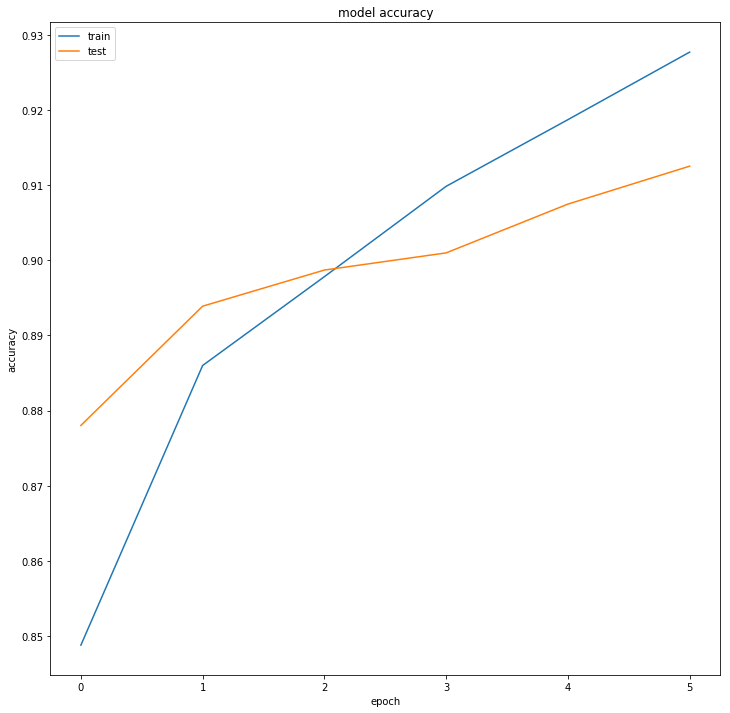

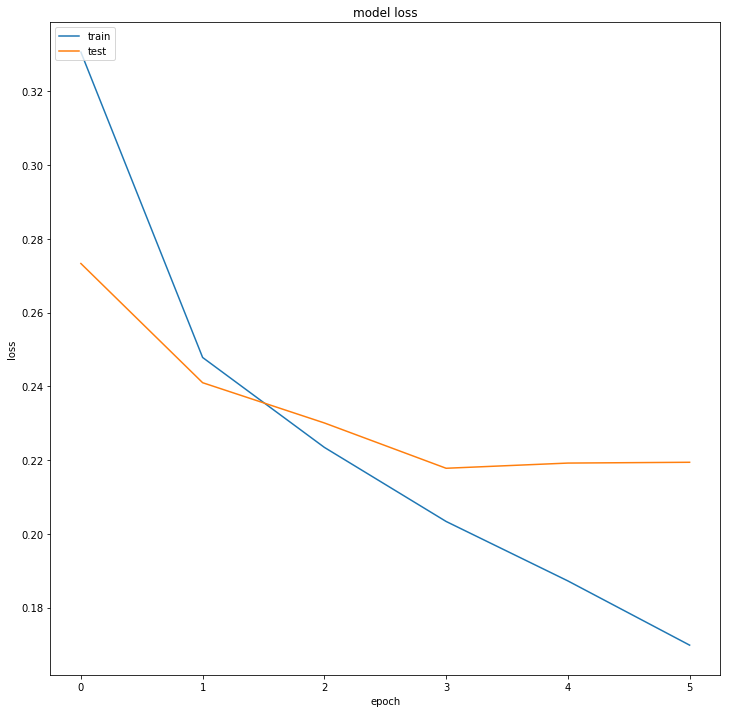

In [15]:
model = Pipeline([
    ('fsa', FixedSizeArray(100, 10)),
    ('nn', NeuralNet(create_LSTM_model(), 'not_simple_LSTM')),
])

model.fit(X_train, y_train)

plot_training(model.steps[1][1].history) 

In [16]:
accuracy_score(model.predict(X_test).argmax(axis=1), y_test.astype(int).argmax(axis=1))

0.8556580295710731

### Conv1d

Lazy loading embeddings...
Train on 24963 samples, validate on 2774 samples
Epoch 1/10
24963/24963 [==============================] - 2s 61us/step - loss: 0.3683 - acc: 0.8378 - val_loss: 0.2842 - val_acc: 0.8727

Epoch 00001: val_loss improved from inf to 0.28416, saving model to weights.tmp.h5
Epoch 2/10
24963/24963 [==============================] - 1s 39us/step - loss: 0.2884 - acc: 0.8684 - val_loss: 0.2796 - val_acc: 0.8737

Epoch 00002: val_loss improved from 0.28416 to 0.27961, saving model to weights.tmp.h5
Epoch 3/10
24963/24963 [==============================] - 1s 38us/step - loss: 0.2737 - acc: 0.8750 - val_loss: 0.2738 - val_acc: 0.8741

Epoch 00003: val_loss improved from 0.27961 to 0.27375, saving model to weights.tmp.h5
Epoch 4/10
24963/24963 [==============================] - 1s 39us/step - loss: 0.2671 - acc: 0.8767 - val_loss: 0.2685 - val_acc: 0.8778

Epoch 00004: val_loss improved from 0.27375 to 0.26854, saving model to weights.tmp.h5
Epoch 5/10
24963/24963 [====

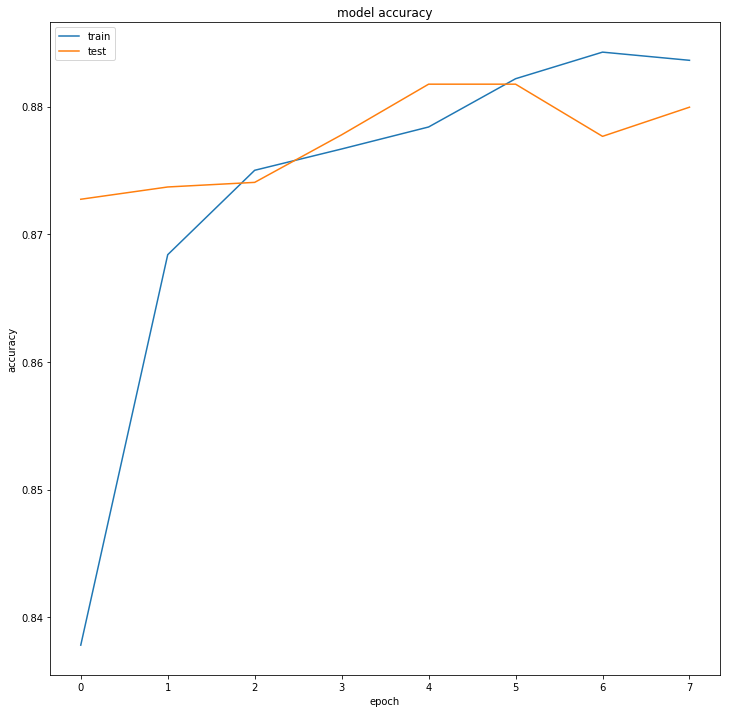

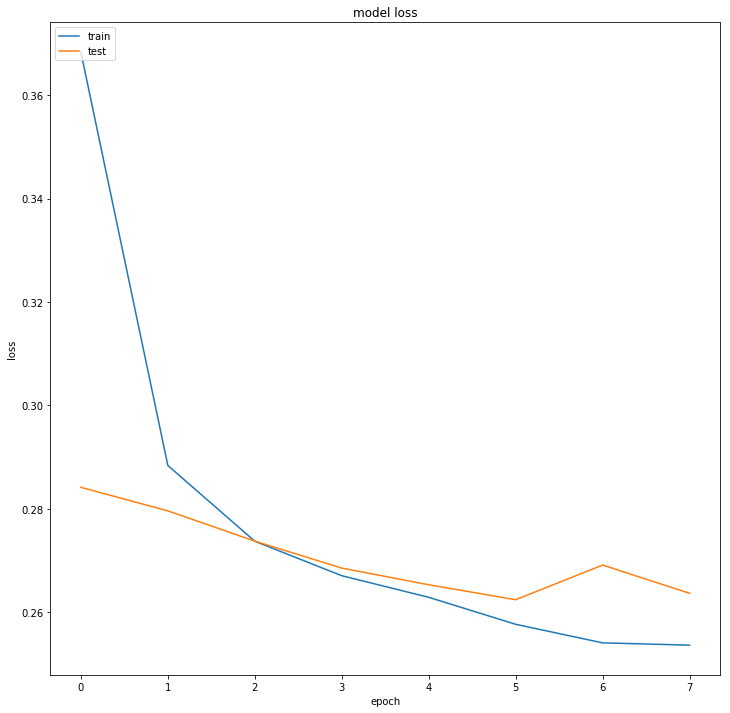

In [18]:
model = Pipeline([
    ('fsa', FixedSizeArray(100, 10)),
    ('nn', NeuralNet(create_conv_model(0.3), 'conv_1d')),
])

model.fit(X_train, y_train)

plot_training(model.steps[1][1].history) 

In [19]:
accuracy_score(model.predict(X_test).argmax(axis=1), y_test.astype(int).argmax(axis=1))

0.8065436978480457